In [1]:
import numpy as np
import matplotlib.pyplot as plt

Dans un IPython notebook il faut rejouter les lignes suivantes pour pouvoir lire un module local. Ce n'est pas nécessaire dans un noyau IPython local ou dans Spyder par exemple...

In [2]:
import sys
import os
dir_module = os.getcwd()
sys.path.append(dir_module)

In [3]:
import elementary_flows as ef

On crée la grille de coordonnées spécifiées par l'énoncé sur le domaine $[-1,2]\times[-0.5,0.5]$ avec 151 points dans chaque direction. On utilise `linspace`pour créer les tableaux 1D, et `meshgrid` pour créer les tableaux 2D. 

In [4]:
npts=151
x = np.linspace(-1,2,npts)
y = np.linspace(-0.5,0.5,npts)
X,Y = np.meshgrid(x,y)

On crée l'écoulement uniforme de vitesse $V_\infty=1 \ m/s$ grâce au module `elementary_flows` et sa classe dédiée `Uniform`. On calcule le champ de vitesse uniforme ainsi que la fonction de courant grâce aux fonctions de la classe sur la grille créée précédemment `X,Y`. 

In [5]:
# Uniform flow
Vinf = 1.0
uniform_flow = ef.Uniform(Vinf)
# Compute velocity 
uniform_flow.velocity(X,Y)
# Compute stream function 
uniform_flow.stream_function(X,Y)


On lit le fichier contenant les coordonnées et l'intensité des sources pour l'exercice 3 

In [6]:
xs,ys,source_strength = np.loadtxt('NACA0012_ex3.txt',skiprows=1,unpack=True)

On crée les sources associées en utilisant la classe `Source` du module `elementary_flows`. On crée pour cela un tableau numpy, en précisant le type `object`, pour stocker les instances des sources. On calcule les champs de vitesse et de courant pour chaque source sur la grille `X,Y`.

In [7]:
N_sources = xs.size
sources = np.empty((N_sources,),dtype='object')
for i in range(N_sources):
    sources[i] = ef.Source(source_strength[i],xs[i],ys[i])
    sources[i].velocity(X,Y)
    sources[i].stream_function(X,Y)

On applique maintenant le principe de superposition. En sommant dans les tableaux `U`, `V` et `PSI` la somme de ces mêmes champs pour chaque écoulement élémentaire.

In [8]:
U = (uniform_flow.u).copy()
V = (uniform_flow.v).copy()
PSI = (uniform_flow.psi).copy()

for si in sources:
    U += si.u
    V += si.v
    PSI += si.psi

On calcule le champ de la norme de vitesse de la superposition. 

In [9]:
Vmag =  np.sqrt( U**2 + V**2 )

On applique le théorème de Bernoulli selon sa forme *forte* car chaque écoulement élémentaire respecte les hypothèses suivantes : 
* Écoulement de fluide parfait
* Écoulement incompressible
* Écoulement irrotationnel
* Écoulement en régime permanent
* Forces extérieures négligées (les effets aérodynamiques sont prépondérant sur l'écoulement)

Ainsi en l'exprimant entre l'infini amont et tout pour du domaine, on peut écrire : 
$$p_\infty + \frac{1}{2}\rho V^2_\infty = p + \frac{1}{2}\rho V^2 $$
On en déduit l'expression du coefficient de pression en tout point de l'écoulement :
$$ C_p = \frac{p-p_\infty}{\frac{1}{2}\rho V^2_\infty} = 1 - \frac{V^2}{V^2_\infty} $$

In [10]:
Cp = 1 - Vmag**2 / Vinf**2

On fait les tracés demandés : cartographies de vitesse et de coefficient de pression. On utilise la fonction `contourf`.

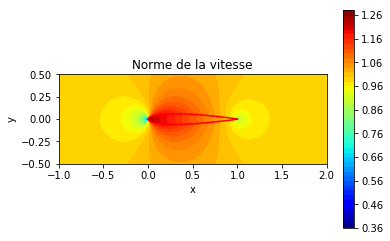

In [11]:
plt.contourf(X,Y,Vmag,50,cmap='jet');
plt.plot(xs,ys,linewidth=1.5,color='red')
plt.xlabel('x');
plt.ylabel('y');
plt.colorbar();
plt.axis('image')
plt.title('Norme de la vitesse');

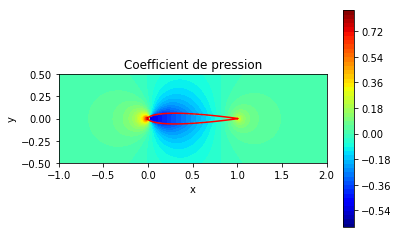

In [12]:
plt.contourf(X,Y,Cp,50,cmap='jet');
plt.plot(xs,ys,linewidth=1.5,color='red')
plt.xlabel('x');
plt.ylabel('y');
plt.colorbar();
plt.axis('image')
plt.title('Coefficient de pression');

On constate que comme pour l'écoulement autour du cylindre sans circulation, les maximum de vitesse sont de part et d'autre du profil et correspondent à des déficits de pression. Le minimum  de vitesse apparait au bord d'attaque et au bord de fuite où le coefficient de pression atteint 1. Il s'agit de points d'arrêt. Le champ de pression est identique dessous et dessus le profil, ainsi comme le profil est symétrique les intégrales de force de pression seront nulles. Il n'y a pas de portance générée sur un profil symétrique sans incidence. C'est ce qui est également observé expérimentalement.

On ne peut pas aller directement chercher les valeurs sur les points des sources car l'écoulement correspond à une singularité. On peut essayer d'aller chercher les points médians entre chaque paire de source. 

In [13]:
xm = 0.5*(xs[1:]+xs[:-1])
ym = 0.5*(ys[1:]+ys[:-1])

On réévalue les écoulements élémentaires sur ces coordonnées

In [14]:
uniform_flow.velocity(xm,ym)
for i in range(N_sources):
    sources[i].velocity(xm,ym)
Um = (uniform_flow.u).copy()
Vm = (uniform_flow.v).copy()

for si in sources:
    Um += si.u
    Vm += si.v
Vmag_m =  np.sqrt( Um**2 + Vm**2 )
Cpm = 1 - Vmag_m**2 / Vinf**2

On peut alors faire le tracé du coefficient de pression sur le profil, en tout cas entre les sources. 

Pour savoir si cela a du sens, le coefficient de pression a été calculé avec `xfoil` pour le  NACA0012, en non-visqueux et à une incidence nulle. Le résultat a été exporté dans le fichier `CP_NACA0012_XFOIL_IVISC.TXT`.

In [15]:
x_xfoil,Cp_xfoil = np.loadtxt('CP_NACA0012_XFOIL_IVISC.TXT',skiprows=1,unpack=True)

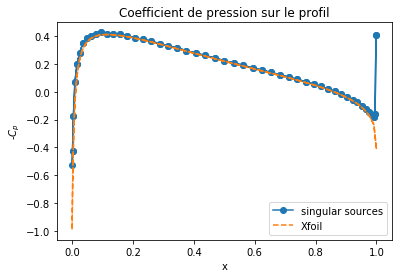

In [19]:
plt.plot(xm,-Cpm,'o-',label='singular sources');
plt.plot(x_xfoil,-Cp_xfoil,'--',label='Xfoil');
plt.xlabel('x');
plt.ylabel('-$C_p$');
plt.legend()
plt.title('Coefficient de pression sur le profil');

Il s'avère que c'est plutôt pas mal comme distribution de pression, sauf proche du bord de fuite